# Pancreas Basics

This tutorial shows how to apply CellRank in order to infer initial or terminal states of a developmental process and how to compute probabilistic fate mappings.  The first part of this tutorial is very similar to [scVelo's tutorial on pancreatic endocrinogenesis](https://scvelo-notebooks.readthedocs.io/Pancreas.html). The data we use here comes from [Bastidas-Ponce et al. (2018)](https://dev.biologists.org/content/146/12/dev173849.abstract). For more info on scVelo, see the [documentation](https://scvelo-notebooks.readthedocs.io/index.html) or read the [article](https://www.nature.com/articles/s41587-020-0591-3). 

This is the **high level mode** to interact with CellRank, which is quick and simple but does not offer as many options as the lower level mode, in which you interact directly with our [kernels](https://cellrank.readthedocs.io/en/latest/classes.html#kernels) and [estimators](https://cellrank.readthedocs.io/en/latest/classes.html#estimators). If you would like to get to know this more advanced way of interacting with CellRank, see the [pancreas advanced](https://cellrank.readthedocs.io/en/latest/pancreas_advanced.html) tutorial.

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/pancreas_basic.ipynb).

## Import packages & data

Easiest way to start is to download [Miniconda3](https://docs.conda.io/en/latest/miniconda.html) along with the environment file found [here](https://raw.githubusercontent.com/theislab/cellrank_notebooks/master/environment.yml). To create the environment, run `conda create -f environment.yml`.

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

First, we need to get the data. The following commands will download the `adata` object and save it under `datasets/endocrinogenesis_day15.5.h5ad`.

In [2]:
adata = cr.datasets.pancreas()
scv.utils.show_proportions(adata)
adata

try downloading from url
https://github.com/theislab/cellrank_notebooks/raw/master/datasets/pancreas/endocrinogenesis_day15.5.h5ad
... this may take a while but only happens once

Abundance of ['spliced', 'unspliced']: [0.81 0.19]


AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## Pre-process the data

Filter out genes which don't have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. Further, compute principal components and moments for velocity estimation. These are standard scanpy/scvelo functions, for more information about them, see the [scVelo API](https://scvelo.readthedocs.io/api.html#preprocessing-pp).

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:03)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Run scVelo

We will use the [dynamical model](https://scvelo.readthedocs.io/DynamicalModeling.html) from scVelo to estimate the velocities. The first step, estimating the parameters of the dynamical model,  may take a while (~10min). To make sure we only have to run this once, we developed a caching extension called [scachepy](https://github.com/theislab/scachepy). scachepy does not only work for `recover_dynamics`, but it can cache the output of almost any scanpy or scvelo function. To install it, simply run 

```
pip install git+https://github.com/theislab/scachepy
```

If you don't want to install scachepy now, don't worry, the below cell will run without it as well and this is the only place in this tutorial where we're using it. 

In [4]:
try:
    import scachepy
    c = scachepy.Cache('../../cached_files/basic_tutorial/')
    c.tl.recover_dynamics(adata, force=False)
except ModuleNotFoundError:
    print("You don't seem to have scachepy installed, but that's fine, you just have to be a bit patient (~10min). ")
    scv.tl.recover_dynamics(adata)

You don't seem to have scachepy installed, but that's fine, you just have to be a bit patient (~10min). 
recovering dynamics
    finished (0:11:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Once we have the parameters, we can use these to compute the velocities and the velocity graph. The velocity graph is a weighted graph that specifies how likely two cells are to transition into another, given their velocity vectors and relative positions. 

In [5]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


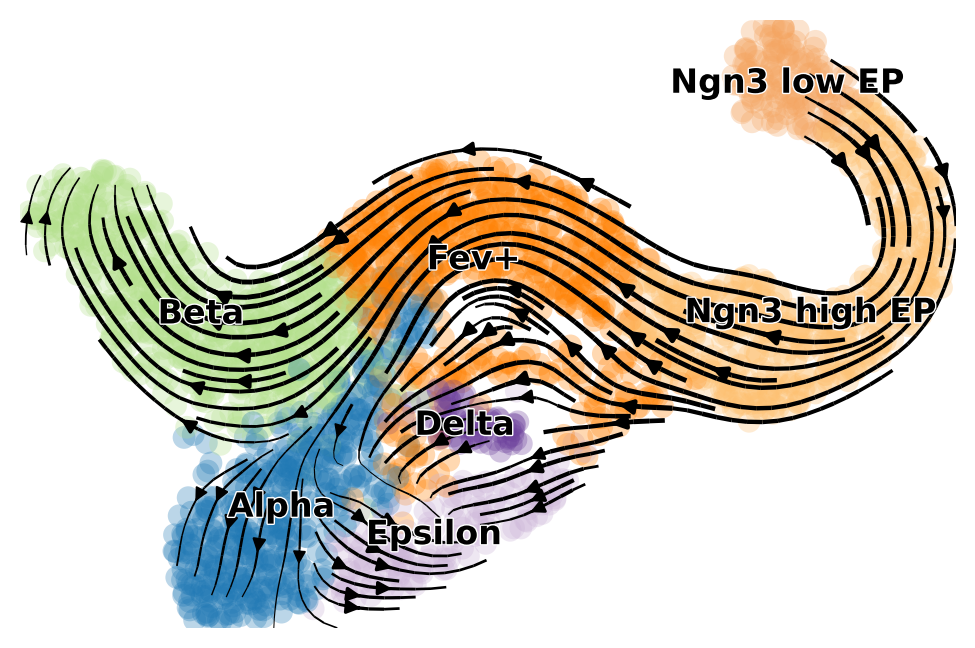

In [6]:
scv.pl.velocity_embedding_stream(adata, basis='umap', legend_fontsize=12, title='', smooth=.8, min_mass=4)

## Run CellRank

CellRank builds on the velocities computed by scVelo to compute initial and terminal states of the dynamical process. It further uses the velocities to calculate how likely each cell is to develop from each initial state or towards each terminal state.

## Identify terminal states

Terminal states can be computed by running the following command:

In [7]:
cr.tl.terminal_states(adata, cluster_key='clusters', weight_connectivities=0.2)

Computing transition matrix based on velocity correlations using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode

Setting `softmax_scale=3.7951`

    Finish (0:00:13)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on connectivities
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `.eigendecomposition`
       `adata.uns['eig_fwd']`
    Finish (0:00:00)
Computing Schur decomposition
Adding `.eigendecomposition`
       `adata.uns['eig_fwd']`
       `.schur`
       `.schur_matrix`
    Finish (0:00:00)
Computing `3` macrostates
INFO: Using pre-computed schur decomposition
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)
Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `adata.obsm['macrostates_fwd']`
       `.terminal_states_probabilities`
       `.termin

The most important parameters in the above function are:

 - `estimator`: this determines what's going to behind the scenes to compute the terminal states. Options are `cr.tl.estimators.CFLARE` ("Clustering and Filtering of Left and Right Eigenvectors") or `cr.tl.estimators.GPCCA` ("[Generalized Perron Cluster Cluster Analysis](https://pubs.acs.org/doi/10.1021/acs.jctc.8b00079)"). The latter is the default, it computes terminal states by coarse graining the velocity-derived Markov chain into a set of macrostates that represent the slow-time scale dynamics of the process, i.e. it finds the states that you are unlikely to leave again, once you have entered them. 
 - `cluster_key`: takes a key from `adata.obs` to retrieve pre-computed cluster labels, i.e. 'clusters' or 'louvain'. These labels are then mapped onto the set of terminal states, to associate a name and a color with each state.
 - `n_states`: number of expected terminal states. This parameter is optional - if it's not provided, this number is estimated from the so-called 'eigengap heuristic' of the spectrum of the transition matrix. 
 - `method`: This is only relevant for the estimator `GPCCA`. It determines the way in which we compute and sort the [real Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition). The default, `krylov`, is an iterative procedure that works with sparse matrices which allows the method to scale to very large cell numbers. It relies on the libraries [SLEPSc](https://slepc.upv.es/) and [PETSc](https://www.mcs.anl.gov/petsc/), which you will have to install separately, see our [installation instructions](https://cellrank.readthedocs.io/en/latest/installation.html). If your dataset is small (<5k cells), and you don't want to install these at the moment, use `method='brandts'`. The results will be the same, the difference is that `brandts` works with dense matrices and won't scale to very large cells numbers.   
 - `weight_connectivities`: additionally to the velocity-based transition probabilities, we use a transition matrix computed on the basis of transcriptomic similarities to make the algorithm more robust. Essentially, we are taking a weighted mean of these two sources of inforamtion, where the weight for transcriptomic similarities is defined by `weight_connectivities`.

When running the above command, CellRank adds a key `terminal_states` to adata.obs and the result can be plotted as:

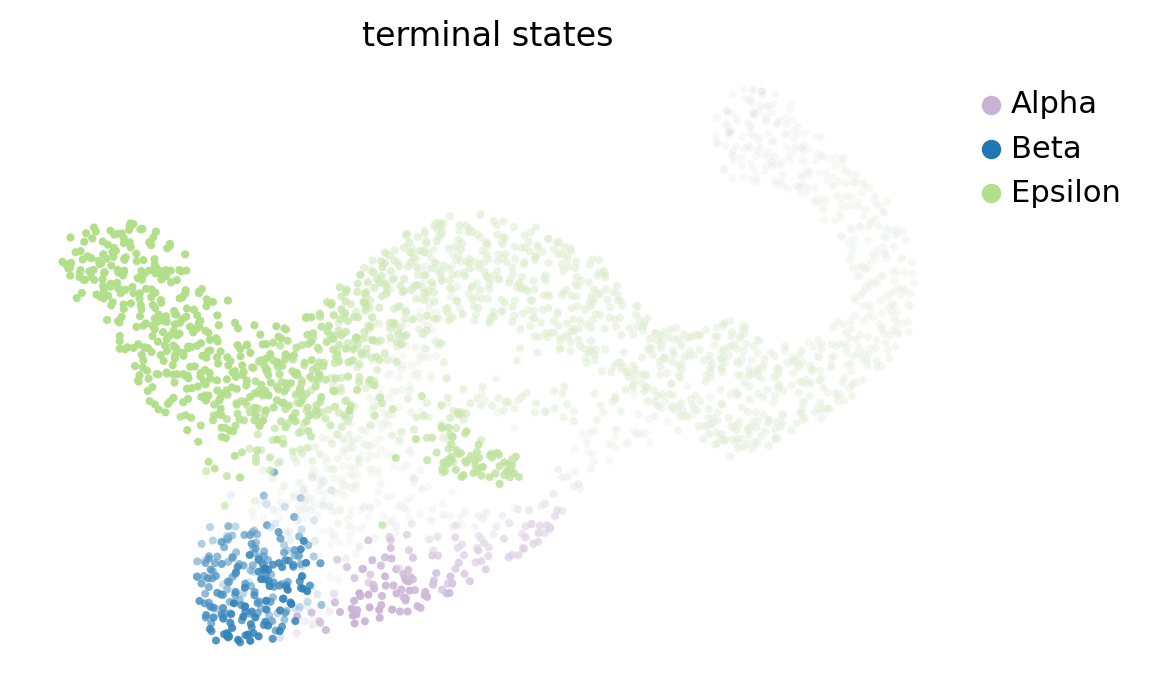

In [8]:
cr.pl.terminal_states(adata)

## Identify initial states

The same sort of analysis can now be repeated for the initial states, only that we use the function `cr.tl.initial_states` this time:

Computing transition matrix based on velocity correlations using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode

Setting `softmax_scale=3.7951`

    Finish (0:00:09)
Computing eigendecomposition of the transition matrix
Adding `.eigendecomposition`
       `adata.uns['eig_bwd']`
    Finish (0:00:00)
Adding `.macrostates_memberships`
        `.macrostates`
    Finish (0:00:00)
Adding `adata.obs['initial_states_probs']`
       `adata.obs['initial_states']`
       `adata.obsm['macrostates_bwd']`
       `.terminal_states_probabilities`
       `.terminal_states`


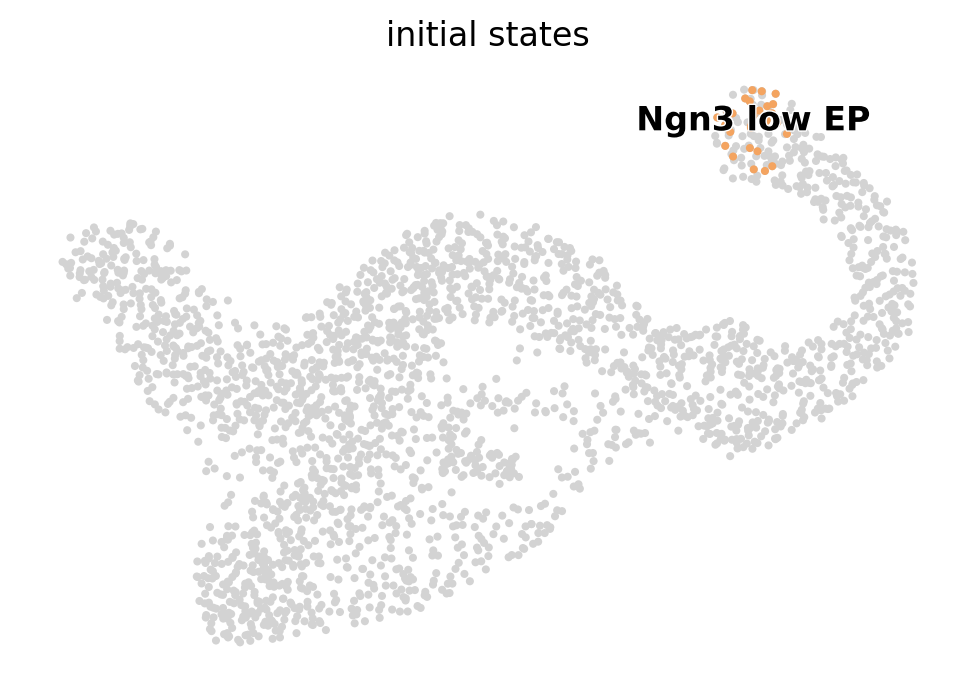

In [9]:
cr.tl.initial_states(adata, cluster_key='clusters') 
cr.pl.initial_states(adata, discrete=True)

We found one initial state, located in the Ngn3 low EP cluster. 

## Compute fate maps

Once we know the terminal states, we can compute associated fate maps - for each cell, we ask how likely is the cell to develop towards each of the identified terminal states. 

Computing lineage probabilities towards terminal states
Computing absorption probabilities
Adding `adata.obsm['to_terminal_states']`
       `adata.obs['to_terminal_states_dp']`
       `.absorption_probabilities`
       `.diff_potential`
    Finish (0:00:00)
Adding lineages to `adata.obsm['to_terminal_states']`
    Finish (0:00:00)


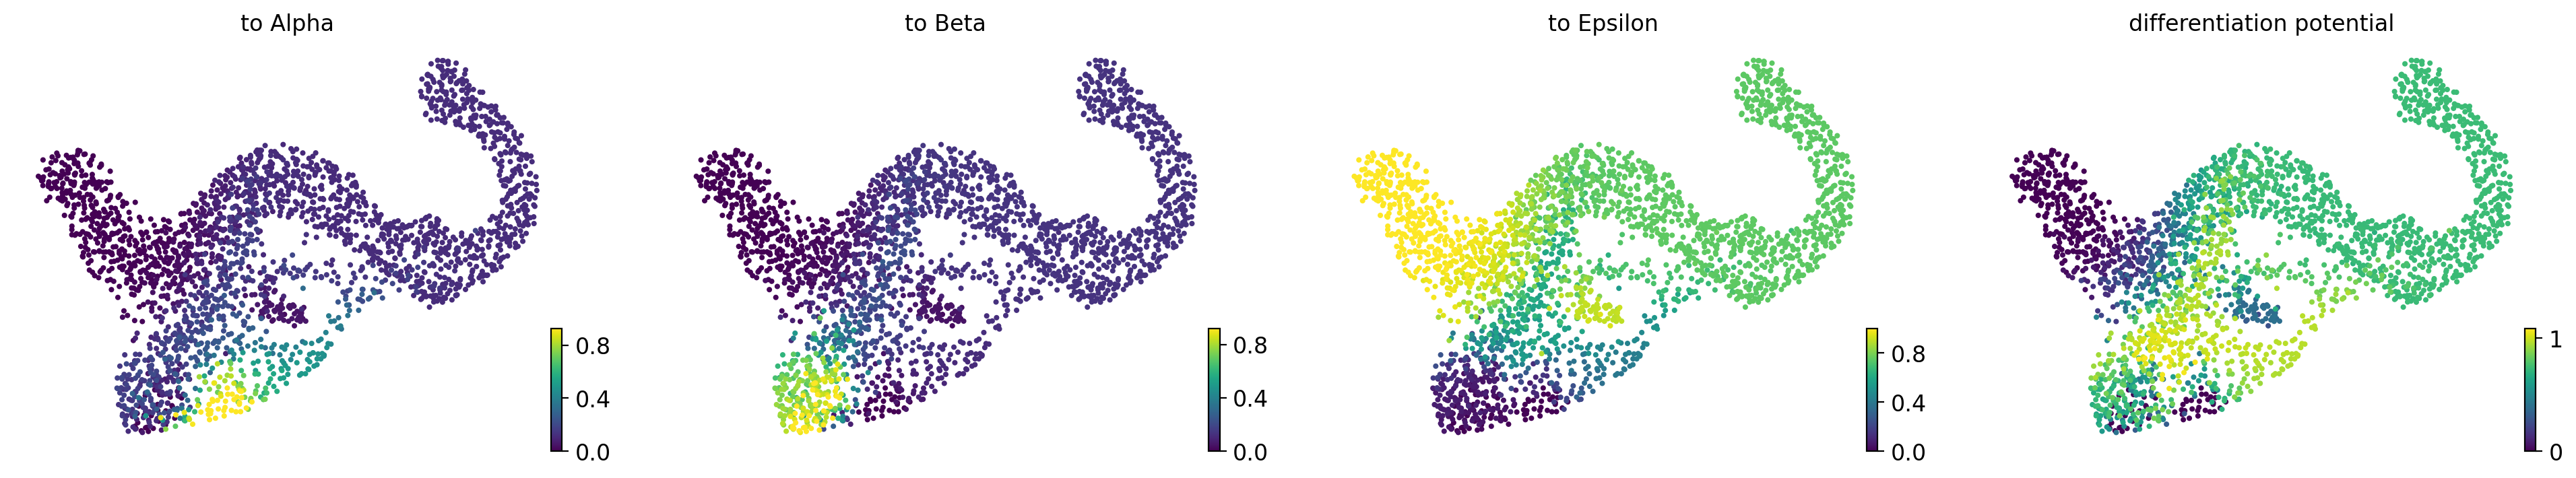

In [10]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False)

We can aggregate the above into a single, global fate map where we associate each terminal state with color and use the intensity of that color to show the fate of each individual cell:

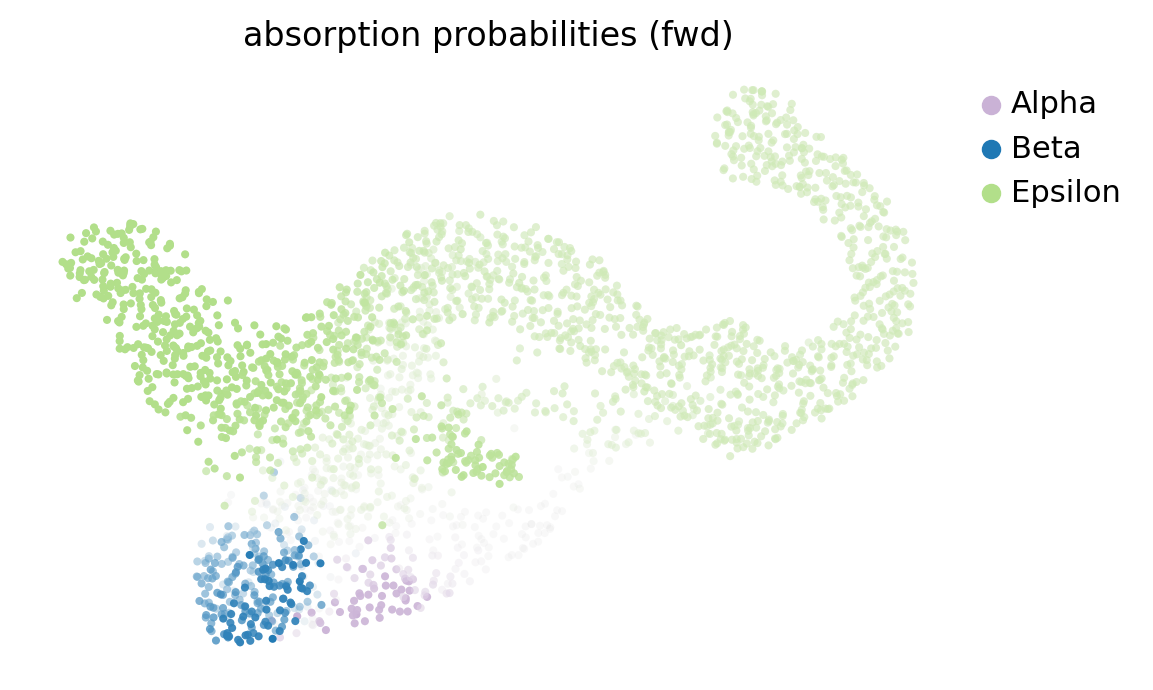

In [11]:
cr.pl.lineages(adata, same_plot=True)

This shows that the dominant terminal state at E15.5 is `Beta`, consistent with known biology, see e.g. [Bastidas-Ponce et al. (2018)](https://dev.biologists.org/content/146/12/dev173849.abstract).

## Directed PAGA

 
We can further aggragate the individual fate maps into a cluster-level fate map using an adapted version of [PAGA](https://scvelo.readthedocs.io/scvelo.tl.paga.html#scvelo.tl.paga) with directed edges. We first compute scVelo's [latent time](https://scvelo.readthedocs.io/scvelo.tl.latent_time.html#scvelo.tl.latent_time) with CellRank identified `root_key` and `end_key`, which are the probabilities of being an initial or a terminal state, respectively.

In [12]:
scv.tl.recover_latent_time(adata, root_key='initial_states_probs', end_key='terminal_states_probs')

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


Next, we can use the inferred pseudotime along with the initial and terminal states probabilities to compute the directed PAGA.

In [13]:
scv.tl.paga(adata, groups='clusters', root_key='initial_states_probs', end_key='terminal_states_probs', 
            use_time_prior='velocity_pseudotime')

running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


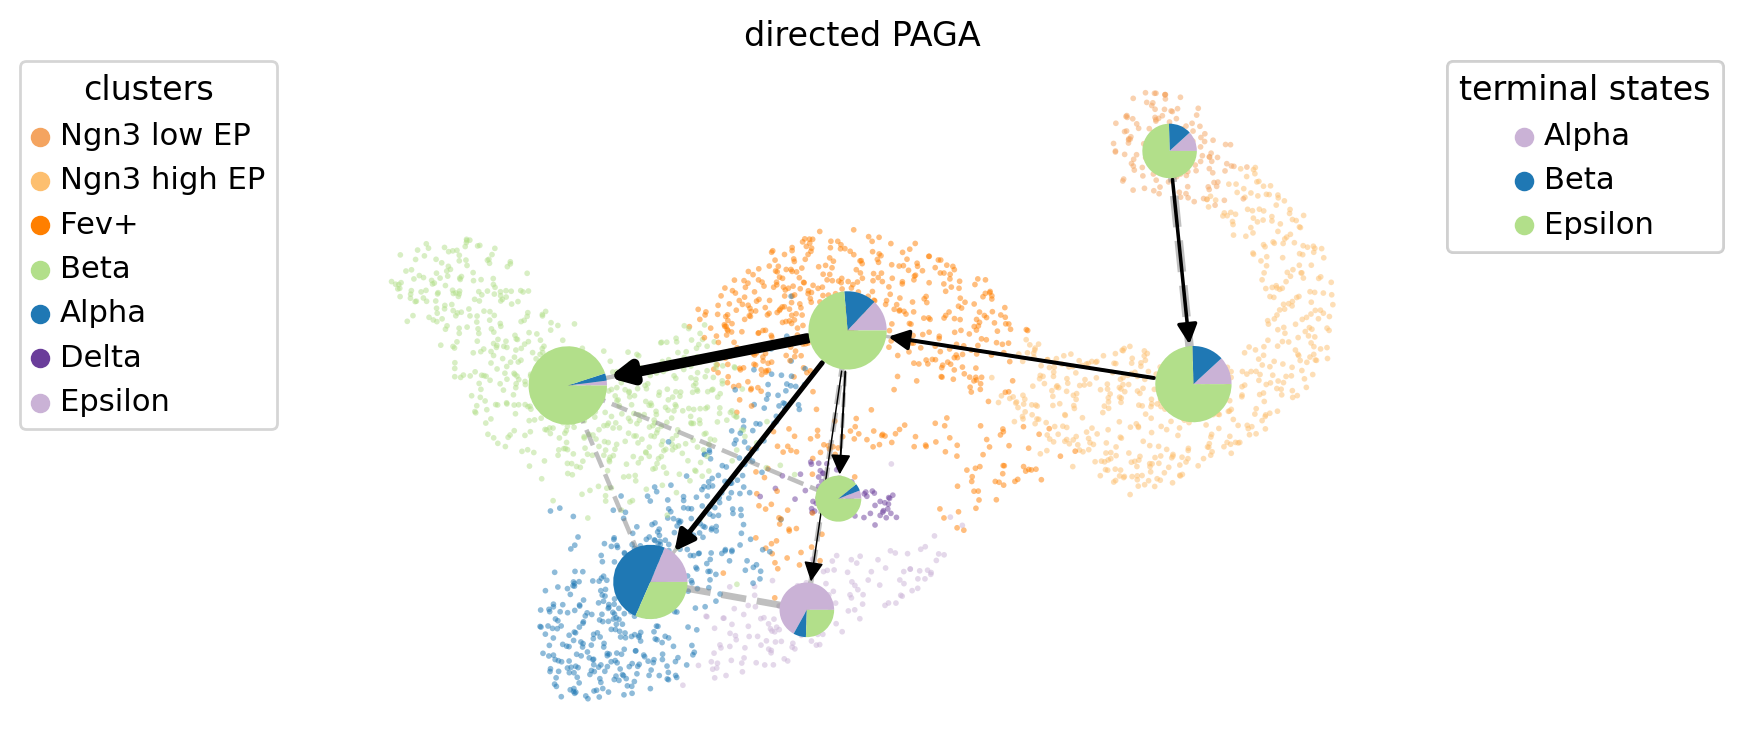

In [14]:
cr.pl.cluster_fates(adata, mode="paga_pie", cluster_key="clusters", basis='umap',
                    legend_kwargs={'loc': 'top right out'}, legend_loc='top left out',
                    node_size_scale=5, edge_width_scale=1, max_edge_width=4, title='directed PAGA')

We use pie charts to show cell fates averaged per cluster. Edges between clusters are given by transcriptomic similarity between the clusters, just as in normal [PAGA](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.paga.html#scanpy.tl.paga). 


Given the fate maps/probabilistic trajectories, we can ask interesting questions like:

- How does expression of a given gene vary along a specified lineage/trajectory ([cellrank.pl.gene_trends](https://cellrank.readthedocs.io/en/latest/gen_modules/cellrank.pl.gene_trends.html#cellrank.pl.gene_trends) and [cellrank.pl.heatmap](https://cellrank.readthedocs.io/en/latest/gen_modules/cellrank.pl.heatmap.html#cellrank.pl.heatmap)?
- How plastic are different cellular subpopulations ([cellrank.pl.cluster_fates(adata, ..., mode='violin')](https://cellrank.readthedocs.io/en/latest/gen_modules/cellrank.pl.cluster_fates.html#cellrank.pl.cluster_fates)?

To find out more, check out the CellRank [API](https://cellrank.readthedocs.io/en/latest/api.html#module-cellrank.pl). 

## Compute lineage drivers

We can compute the driver genes for all or just the subset of lineages. We can also restric this to some subset of clusters by specifying `clusters=...` (not shown below).

In [15]:
cr.tl.lineage_drivers(adata)

Computing correlations for lineages `['Alpha' 'Beta' 'Epsilon']` restricted to clusters `None` in layer `X` with `use_raw=False`
Adding `.lineage_drivers`
       `adata.var['to Alpha']`
       `adata.var['to Beta']`
       `adata.var['to Epsilon']`
    Finish (0:00:00)


Afterwards, we can plot the top 5 driver genes, e.g. for the `Alpha` lineage:

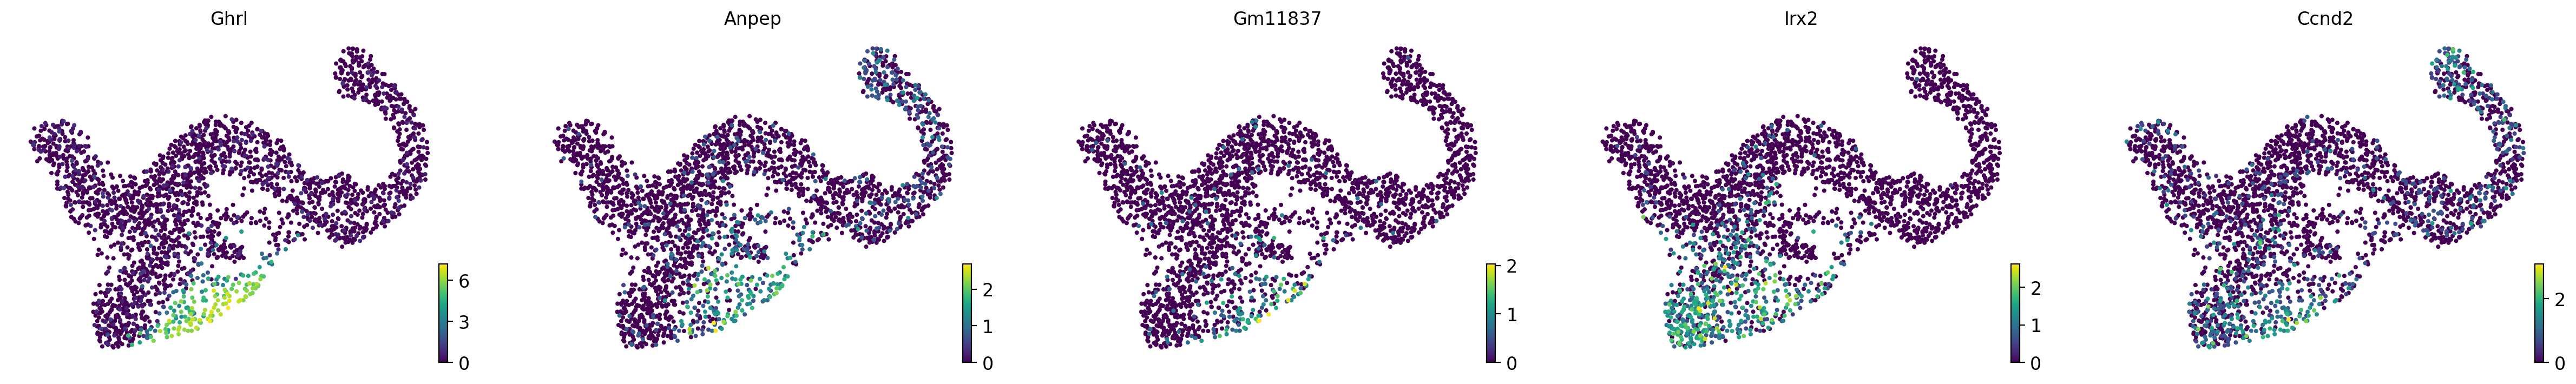

In [16]:
cr.pl.lineage_drivers(adata, lineage="Alpha", n_genes=5)

## Plot smooth gene expression trends along trajectories

The functions demonstrated above are the main functions of CellRank: computing initial and terminal states and probabilistic fate maps. We can use the computed probabilites now to e.g. smooth gene expression trends along lineages. 

Let's start with a temporal ordering for the cells. To get this, we can compute scVelo's [latent time](https://scvelo.readthedocs.io/scvelo.tl.latent_time.html#scvelo.tl.latent_time), as computed previously, or alternatively, we can just use CellRank's initial states to compute a [Diffusion Pseudotime](https://doi.org/10.1038/nmeth.3971). 

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99748987 0.9902442  0.9816529  0.9754233  0.96905994
     0.9629265  0.956972   0.94059503 0.9212148  0.9155121  0.8986904
     0.8907604  0.8846064  0.8736002 ]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


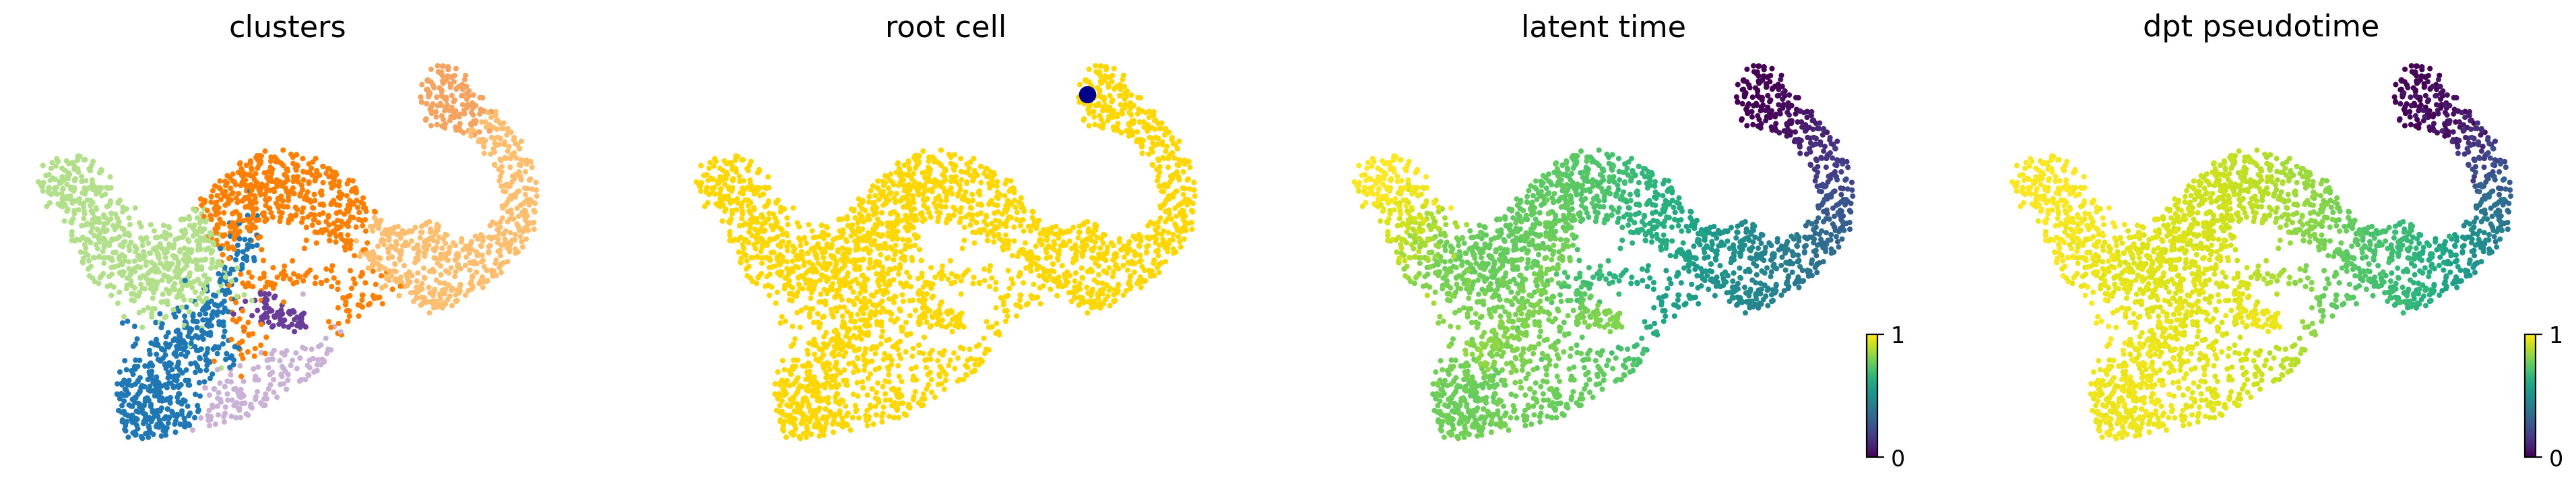

In [17]:
# compue dpt, starting from CellRank defined root cell
root_idx = np.where(adata.obs['initial_states'] == 'Ngn3 low EP')[0][0]
adata.uns['iroot'] = root_idx
sc.tl.dpt(adata)

scv.pl.scatter(adata, color=['clusters', root_idx, 'latent_time', 'dpt_pseudotime'], fontsize=16,
               cmap='viridis', perc=[2, 98], colorbar=True, rescale_color=[0, 1], 
               title=['clusters', 'root cell', 'latent time', 'dpt pseudotime'])

We can plot dynamics of genes in pseudotime along individual trajectories, defined via the fate maps we computed above.

Computing trends using `1` core(s)

    Finish (0:00:01)
Plotting trends


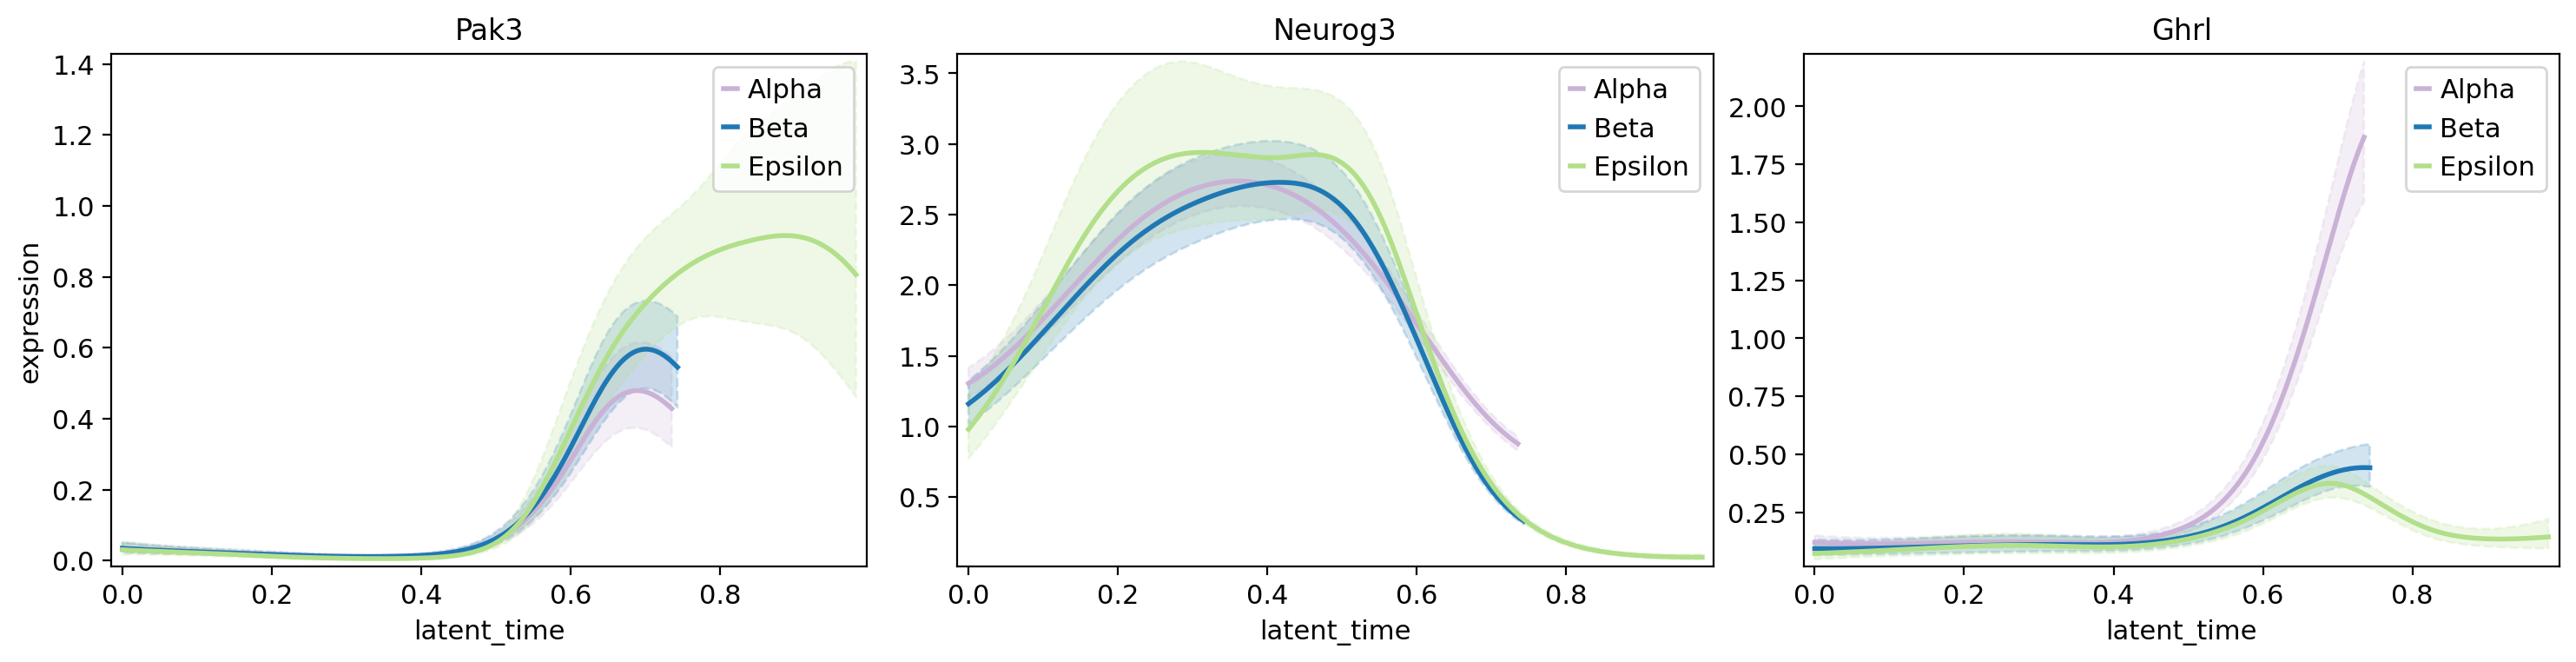

In [18]:
model = cr.ul.models.GAM(adata)
cr.pl.gene_trends(adata, model=model, data_key='X',
                  genes=['Pak3','Neurog3', 'Ghrl'], ncols=3,
                  time_key='latent_time', same_plot=True, hide_cells=True,
                  figsize=(15, 4), n_test_points=200)

We can also visualize the lineage driver computed above in a heatmap:

Computing trends using `4` core(s)

    Finish (0:00:19)


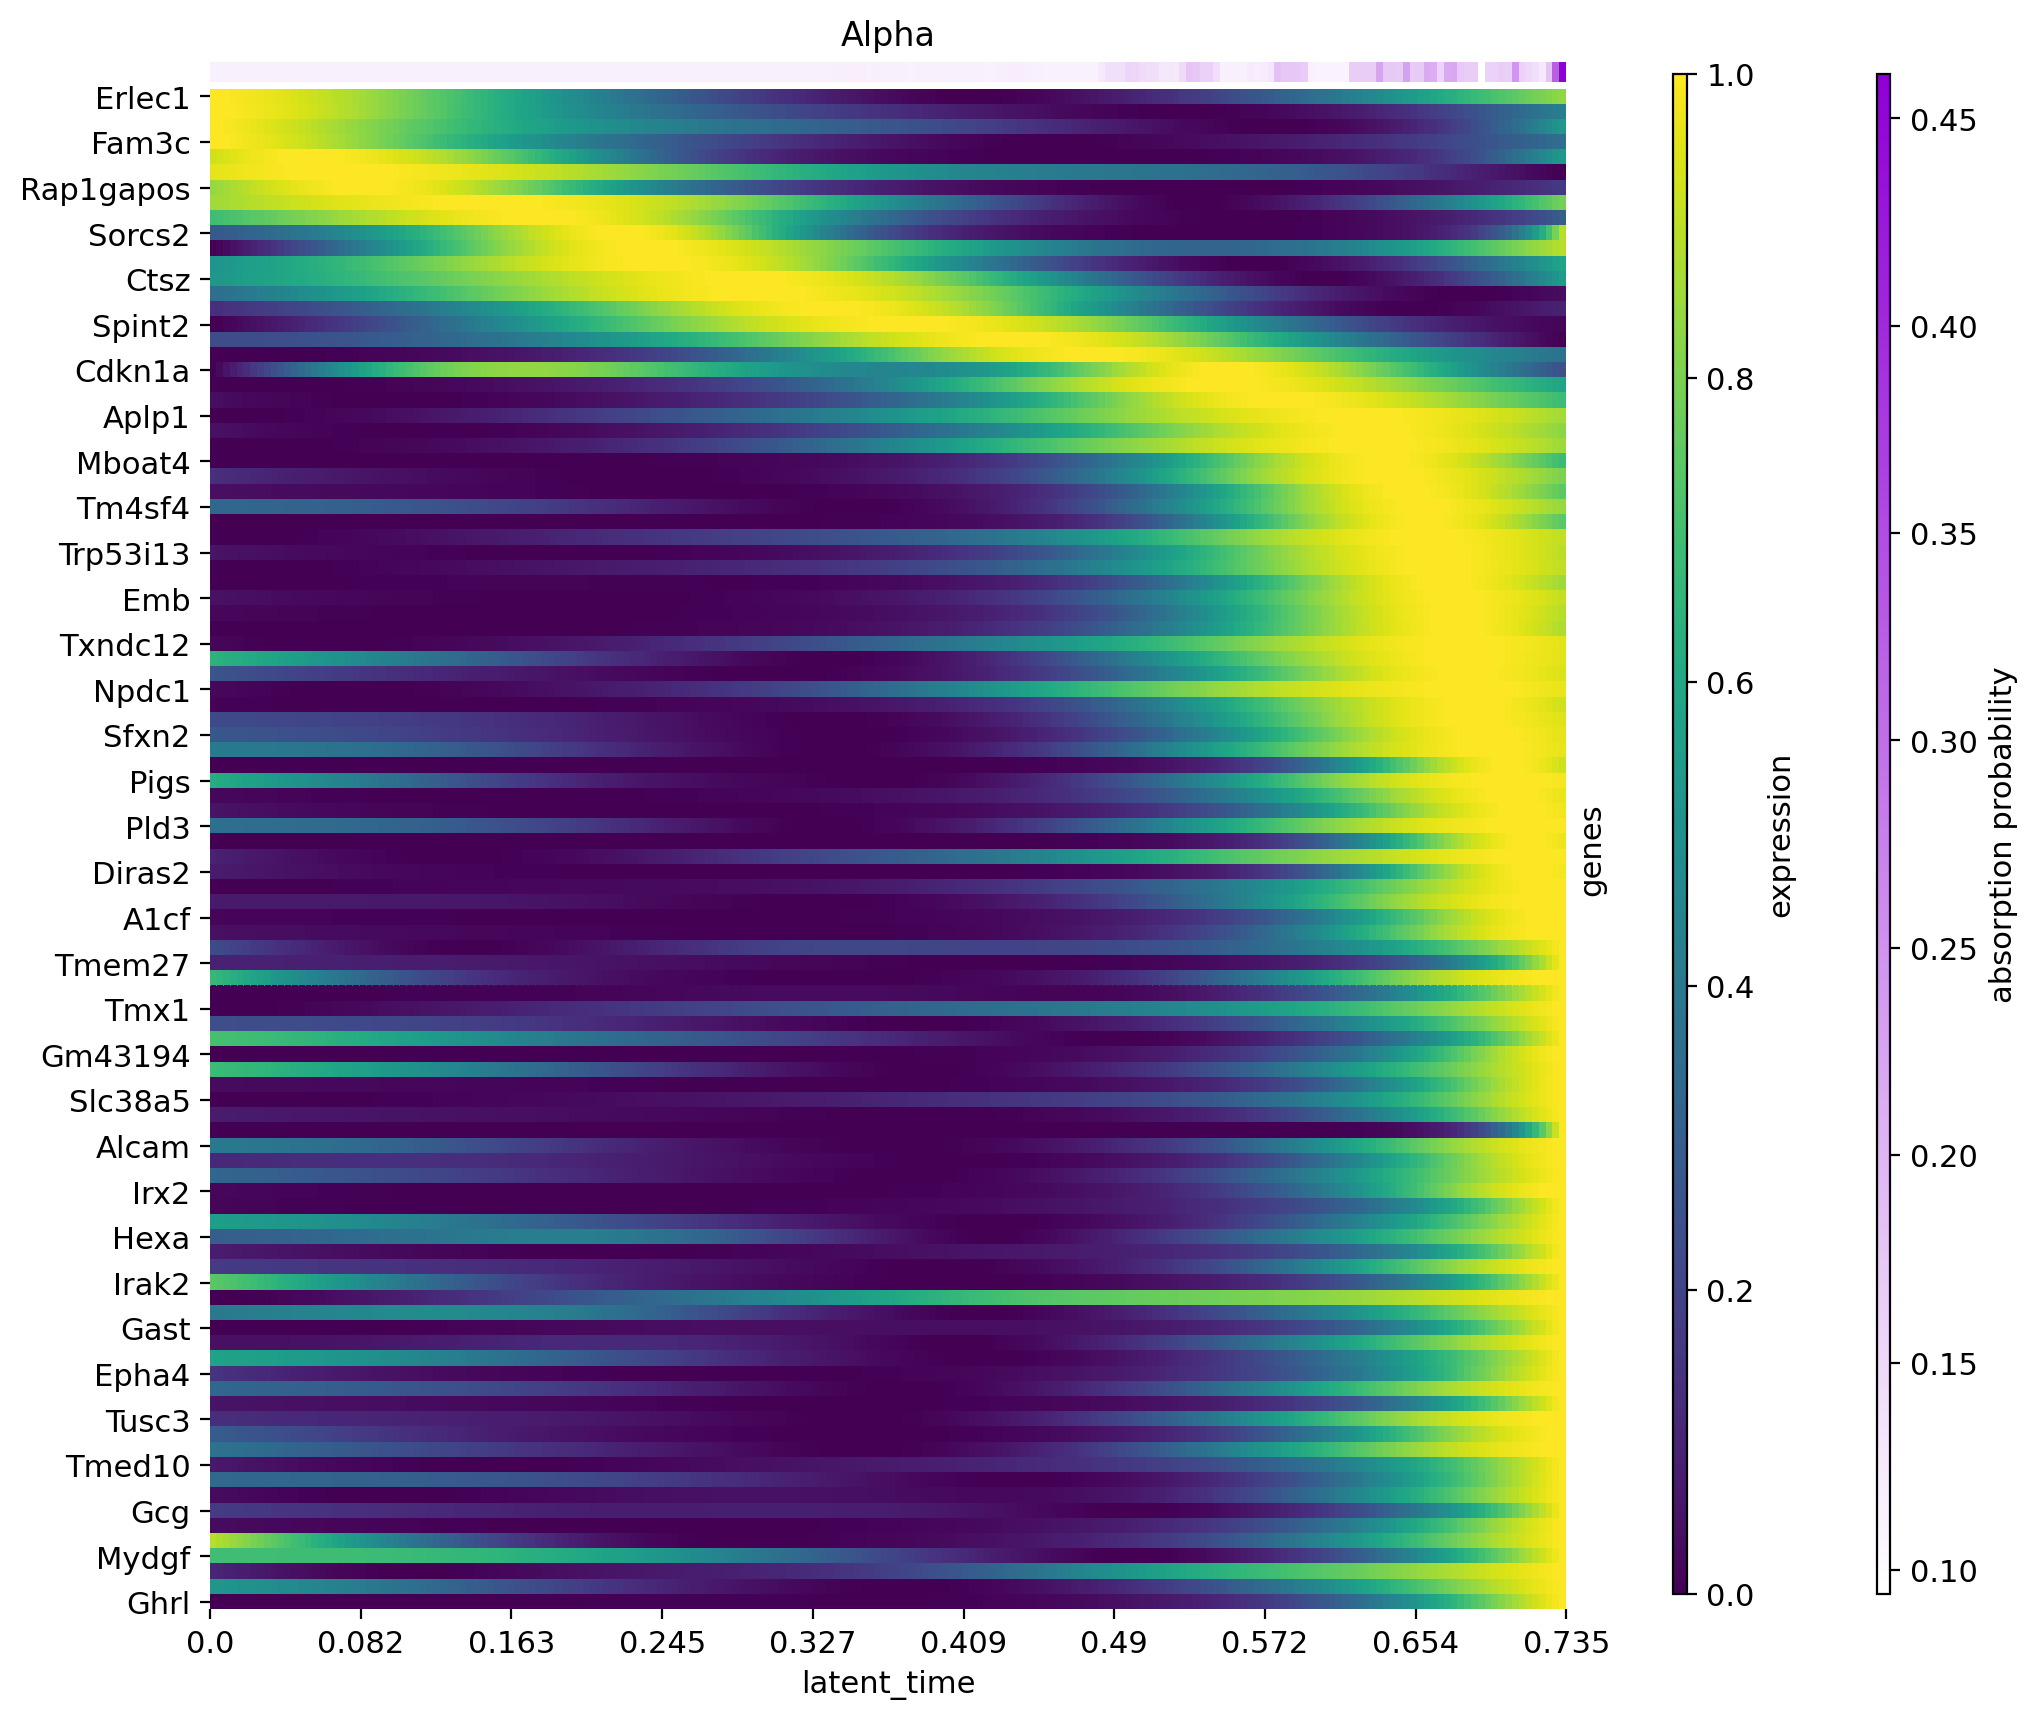

In [19]:
cr.pl.heatmap(adata, model, genes=adata.var['to Alpha'].sort_values(ascending=False).index[:100],
              show_absorption_probabilities=True,
              lineages="Alpha", n_jobs=4, backend='loky')